In [17]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from musint.datasets.babel_dataset import BabelDataset
from musint.datasets.amass_dataset import get_feat_p
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

MIA_MUSCLES = [
    "quadriceps_femoris_l",
    "hamstring_l",
    "lateral_l",
    "biceps_l",
    "quadriceps_femoris_r",
    "hamstring_r",
    "lateral_r",
    "biceps_r",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import torch


def pearson_corr(x, y):
    # x and y are of shape (B, T, C)
    B, T, C = x.shape

    mean_x = torch.mean(x, dim=1, keepdim=True)
    mean_y = torch.mean(y, dim=1, keepdim=True)

    std_x = torch.std(x, dim=1, keepdim=True, unbiased=False)
    std_y = torch.std(y, dim=1, keepdim=True, unbiased=False)

    y_norm = (y - mean_y) / (std_y + 1e-8)
    x_norm = (x - mean_x) / (std_x + 1e-8)

    numerator = torch.sum(x_norm * y_norm, dim=1)
    denominator = T - 1
    pcorrs = numerator / denominator

    mean_pcorr = torch.mean(pcorrs, dim=-1)

    return mean_pcorr, pcorrs


def smape(x, y):
    # x and y are of shape (B, T, C)
    B, T, C = x.shape

    numerator = torch.abs(x - y)
    denominator = (torch.abs(x) + torch.abs(y)) / 2.0

    smape_values = numerator / (denominator + 1e-8)  # Add small value to avoid division by zero
    smape_per_channel = torch.mean(smape_values, dim=1) * 100  # Compute mean across time dimension

    mean_smape = torch.mean(smape_per_channel, dim=-1)  # Compute mean across channels

    return mean_smape, smape_per_channel


def compute_loss(Loss, pred_muscle_act, gt_muscle_act):
    loss_muscle_act = Loss.forward_naive(pred_muscle_act, gt_muscle_act)
    return loss_muscle_act

In [21]:
import os
import numpy as np
from tqdm import tqdm


# Function to load data from a directory
def load_data(base_dir):
    gt_data = {}
    pred_data = {}
    subject_data = {}
    action_data = {}

    # Walk through all subdirectories and files
    for root, _, files in tqdm(os.walk(base_dir)):
        for file in files:
            if file.endswith("_gt.npy") or file.endswith("_pred.npy"):
                # Extract information from the file path and name
                relative_path = os.path.relpath(root, base_dir)
                subject, action = relative_path.split(os.sep)[:2]
                file_id = file.split("_")[0]

                # Load the numpy file
                file_path = os.path.join(root, file)
                try:
                    data_array = np.load(file_path)
                except Exception as e:
                    print(f"Failed to load {file_path}: {e}")
                    continue

                # Create dictionary key
                data_key = f"{subject}/{action}/{file_id}"

                subject_data[data_key] = subject
                action_data[data_key] = action

                # Store ground truth and prediction data
                if file.endswith("_gt.npy"):
                    gt_data[data_key] = data_array
                else:
                    pred_data[data_key] = data_array

    return gt_data, pred_data, subject_data, action_data


# Example usage
base_directory = "output/MIA/transformer/16_trans_layers_256_width_28frames/transformer/val"
gt_data, pred_data, subject_data, action_data = load_data(base_directory)

print(f"Number of samples: {len(set(subject_data))}")
sample_key = next(iter(subject_data))
print(f"{subject_data[sample_key]} {action_data[sample_key]}")
index = 0  # Initialize index variable

subset_actions = [
    "overall",
    "ElbowPunch",
    "FrontKick",
    "FrontPunch",
    "HighKick",
    "HookPunch",
    "JumpingJack",
    "KneeKick",
    "LegBack",
    "LegCross",
    "RonddeJambe",
    "Running",
    "Shuffle",
    "SideLunges",
    "SlowSkater",
    "Squat",
    "overall",
]  # List to store subset actions

print(f"\nMuscle subset: {MIA_MUSCLES}\n")
muscle_idxs = list(range(8))

print(base_directory)

pct99_norm = torch.tensor([123.0, 70.0, 138.0, 119.0, 140.0, 71.0, 113.0, 103.0])

print("Action & RMSE & PCorr & SMAPE")  # Print table header
for subset_action in subset_actions:
    squared_errors = []  # List to store squared error values
    motion = "jump"  # Specify the motion type
    show_plot = False  # Flag to control plotting
    min_loss = float("inf")  # Initialize minimum loss
    max_loss = float("-inf")  # Initialize maximum loss
    min_loss_sample = None  # Initialize minimum loss sample
    max_loss_sample = None  # Initialize maximum loss sample
    all_losses = []  # List to store all loss values
    keys = []
    indices = []
    preds = []  # List to store predictions
    gts = []  # List to store ground truths
    acts = []  # List to store actions
    mean_pcorrs = []  # List to store mean pearson correlation values
    pcorr_cs = []  # List to store pearson correlation values by channel

    mean_smapes = []  # List to store mean smape values
    smapes_c = []  # List to store smape values by channel

    sub_meta_df = None

    # Iterate over each row in the metadata DataFrame
    for key, gt in gt_data.items():
        if subset_action == "overall":
            pass
        else:
            if action_data[key] != subset_action:
                continue

        keys.append(key)
        pred = pred_data[key]  # Get prediction data

        # Convert numpy arrays to torch tensors
        torch_gt = torch.from_numpy(gt)
        torch_pred = torch.from_numpy(pred)

        torch_gt = torch_gt * pct99_norm
        torch_pred = torch_pred * pct99_norm

        mean_pcorr, pcorr_c = pearson_corr(torch_gt, torch_pred)
        mean_pcorrs.append(mean_pcorr)  # Append mean pearson correlation to list
        pcorr_cs.append(pcorr_c)  # Append pearson correlation to list

        mean_smape, smape_c = smape(torch_gt, torch_pred)
        mean_smapes.append(mean_smape)  # Append mean smape to list
        smapes_c.append(smape_c)  # Append smape to list

        # Append ground truth and prediction to lists
        gts.append(torch_gt)
        preds.append(torch_pred)

    gts = torch.cat(gts)  # Stack ground truths
    preds = torch.cat(preds)  # Stack predictions
    mean_smapes = torch.cat(mean_smapes)  # Stack mean smapes

    mean_pcorrs = torch.cat(mean_pcorrs)  # Stack mean pearson correlations
    pcorr_cs = torch.cat(pcorr_cs)  # Stack pearson correlations

    # Compute overall mean squared error and root mean squared error
    rmse = torch.sqrt(F.mse_loss(preds, gts))
    avgpcorr = torch.mean(mean_pcorrs)
    avgsmape = torch.mean(mean_smapes)
    print(
        f"{subset_action:{7}s} ({len(gts):{3}}) & {round(rmse.item(), 3):.2f} & {round(avgpcorr.item(),2):.2f} & {round(avgsmape.item(),1):.1f}"
    )  # Print overall RMSE

143it [00:43,  3.32it/s]


Number of samples: 3000
Subject3 HighKick

Muscle subset: ['quadriceps_femoris_l', 'hamstring_l', 'lateral_l', 'biceps_l', 'quadriceps_femoris_r', 'hamstring_r', 'lateral_r', 'biceps_r']

output/MIA/transformer/16_trans_layers_256_width_28frames/transformer/val
Action & RMSE & PCorr & SMAPE
overall (3000) & 15.18 & 0.28 & 36.8
ElbowPunch (201) & 15.59 & 0.25 & 42.9
FrontKick (200) & 8.36 & 0.22 & 33.9
FrontPunch (213) & 8.50 & 0.38 & 29.7
HighKick (182) & 13.10 & 0.36 & 36.3
HookPunch (200) & 13.08 & 0.32 & 37.2
JumpingJack (200) & 13.67 & 0.27 & 28.8
KneeKick (188) & 12.33 & 0.27 & 36.6
LegBack (208) & 11.80 & 0.33 & 36.4
LegCross (182) & 13.94 & 0.17 & 42.5
RonddeJambe (220) & 15.88 & 0.23 & 39.5
Running (200) & 7.59 & 0.30 & 26.9
Shuffle (198) & 9.91 & 0.22 & 28.2
SideLunges (202) & 25.82 & 0.29 & 45.5
SlowSkater (201) & 20.55 & 0.26 & 42.8
Squat   (205) & 23.30 & 0.25 & 45.7
overall (3000) & 15.18 & 0.28 & 36.8


In [9]:
gts.shape

gts_max_act, _ = gts.max(dim=-2)
gts_max_act.max(dim=0)
gts_max_act.shape

# Create an empty array to store the AUC values for each muscle in each frame
auc_values = np.zeros((3000, 8))

# Iterate over each sample in the tensor
for i in range(3000):
    # Iterate over each muscle in the sample
    for j in range(8):
        # Calculate the AUC for the muscle in its 28 frame window using the trapezoidal rule
        auc_values[i, j] = np.trapz(gts[i, :, j], dx=1)

auc_values = auc_values / 28.0

In [10]:
auc_values

array([[36.10290557, 18.73547215,  5.27633172, ..., 13.43099274,
         2.69007264, 13.41192494],
       [31.56083535, 19.08504843,  3.19794189, ..., 13.87530266,
         3.22578692,  7.97820823],
       [22.67645278,  9.58383777,  3.84261501, ..., 15.88559322,
         2.45702179,  9.08686441],
       ...,
       [ 3.73970944,  8.11985472, 11.13196126, ..., 15.57990315,
         6.79903148, 17.96186441],
       [28.08020581, 36.53450363, 56.55417676, ..., 30.47820823,
        61.54207022, 55.12590799],
       [14.0066586 , 27.66828087, 40.37530266, ..., 13.40102906,
        75.61985472, 53.9966707 ]])

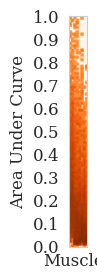

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set_style(style="whitegrid")
# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (4, 3),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)

# Assuming you have the tensor `muscle_activations` with shape (602, 28, 402)

# Flatten the tensor to have shape (602, 402)
flattened_activations = auc_values

# Create an empty array to store the histogram values for each muscle
histogram_values = np.zeros((100, 8))
median_bins = np.zeros(8)

# Iterate over each muscle (column) in the flattened tensor
for i in range(8):
    # Calculate the histogram values for the muscle with 100 bins
    hist, _ = np.histogram(flattened_activations[:, i], bins=100, range=(0, 1))
    # Store the histogram values in the empty array
    histogram_values[:, i] = hist

    # Calculate the cumulative distribution function (CDF) for the muscle
    cdf = np.cumsum(hist) / np.sum(hist)
    # Find the bin index that corresponds to the median value (0.5) in the CDF
    median_bin_index = np.argmax(cdf >= 0.5)
    # Store the median bin index for the muscle
    median_bins[i] = median_bin_index

# Normalize the histogram values to the range [0, 1]
histogram_values = histogram_values / 3000.0
histogram_values += 1e-6

# Sort the histograms based on their median bins
sorted_indices = np.argsort(median_bins)

# Reorder the columns of the histogram_values array based on the sorted indices
histogram_values = histogram_values[:, sorted_indices[::-1]]

# Create a logarithmic color map from 0 to 1
norm = LogNorm(vmin=np.min(histogram_values[histogram_values > 0]), vmax=np.max(histogram_values))

# Plot the histogram values as a two-dimensional color-coded histogram with logarithmic color map
plt.imshow(
    histogram_values,
    # aspect="auto",
    cmap="Oranges",
    origin="lower",
    # vmin=np.min(histogram_values[histogram_values > 0]),
    # vmax=0.2,
    norm=norm,
)
# Inverse the y-axis
# Set the y-axis ticks to go from 0 to 1
plt.yticks(np.linspace(0, 100, 11), np.round(np.linspace(0, 1, 11), decimals=2))
# plt.colorbar(label="Bin Counts")
plt.xlabel("Muscles")
plt.ylabel("Area Under Curve")
# plt.title("Histogram of Activation Area Under Curve", y=1.05)
# Deactivate the x-axis ticks
plt.xticks([])
# Deactivate the grid
plt.grid(False)
plt.savefig(f"muscle_auc.svg")
plt.show()

In [7]:
from matplotlib import colormaps

list(colormaps)

['magma',
 'inferno',
 'plasma',
 'viridis',
 'cividis',
 'twilight',
 'twilight_shifted',
 'turbo',
 'Blues',
 'BrBG',
 'BuGn',
 'BuPu',
 'CMRmap',
 'GnBu',
 'Greens',
 'Greys',
 'OrRd',
 'Oranges',
 'PRGn',
 'PiYG',
 'PuBu',
 'PuBuGn',
 'PuOr',
 'PuRd',
 'Purples',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'RdYlGn',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'afmhot',
 'autumn',
 'binary',
 'bone',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'cubehelix',
 'flag',
 'gist_earth',
 'gist_gray',
 'gist_heat',
 'gist_ncar',
 'gist_rainbow',
 'gist_stern',
 'gist_yarg',
 'gnuplot',
 'gnuplot2',
 'gray',
 'hot',
 'hsv',
 'jet',
 'nipy_spectral',
 'ocean',
 'pink',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'terrain',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Pastel1',
 'Pastel2',
 'Set1',
 'Set2',
 'Set3',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 'grey',
 'gist_grey',
 'gist_yerg',
 'Grays',
 'magma_r',
 'inferno_r',
 'plasma_r',
 'viri

In [11]:
# Mapping of muscle identifiers to their full names
muscle_idxs = list(range(8))


full_muscle_names = {
    "quadriceps_femoris_l": "Quad. Fem. (L)",
    "hamstring_l": "Ham. (L)",
    "lateral_l": "Lat. (L)",
    "biceps_l": "Bi. (L)",
    "quadriceps_femoris_r": "Quad. Fem. (R)",
    "hamstring_r": "Ham. (R)",
    "lateral_r": "Lat. (R)",
    "biceps_r": "Bi. (R)",
}

sample_indices = np.random.choice(3000, 10, replace=False)
# jumping jacks, kick, run, walk, jump

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


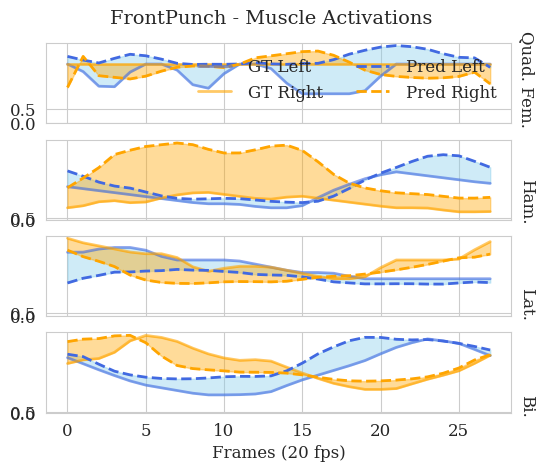

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


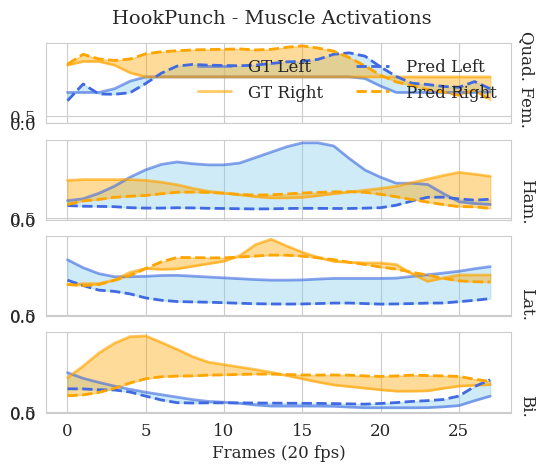

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


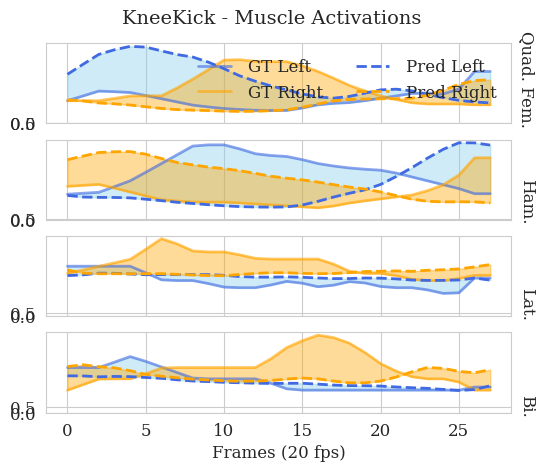

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


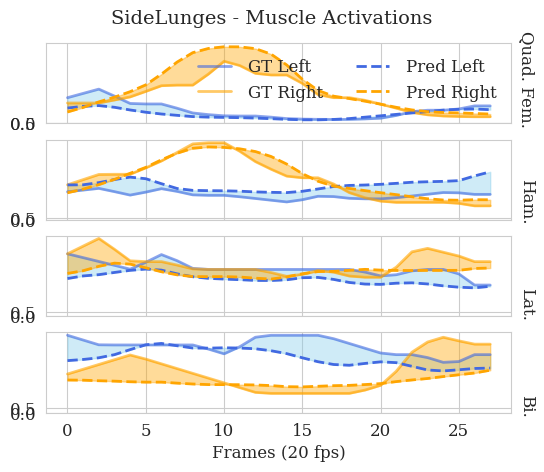

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


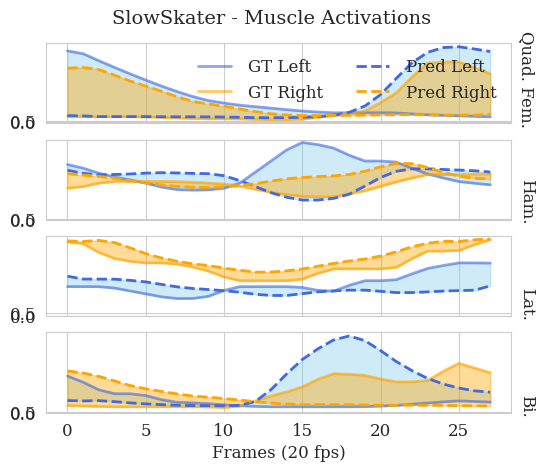

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


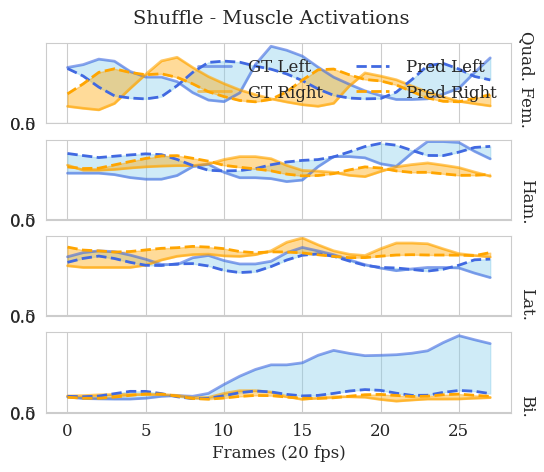

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


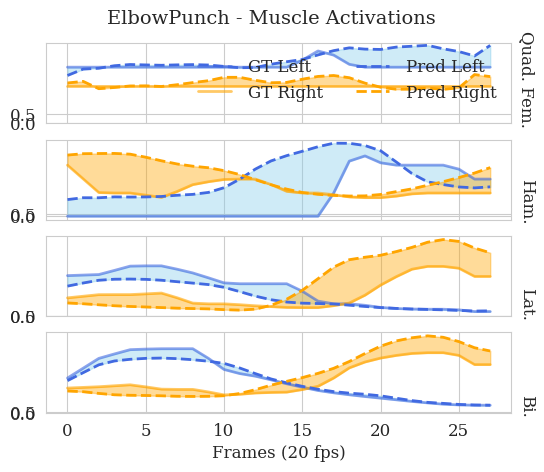

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


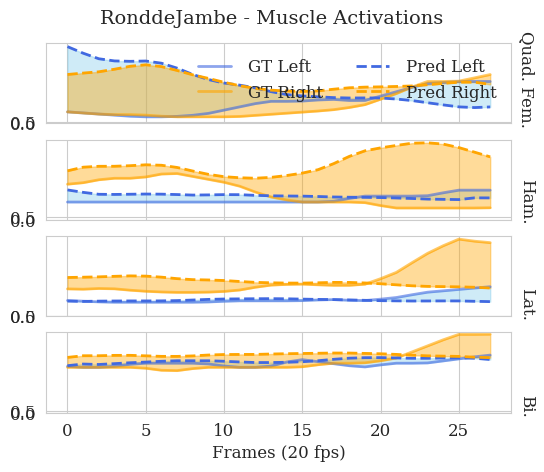

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


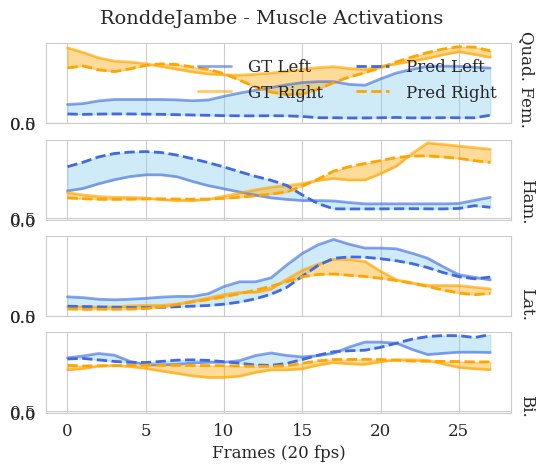

/tmp/ipykernel_2042400/2858142897.py:92: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


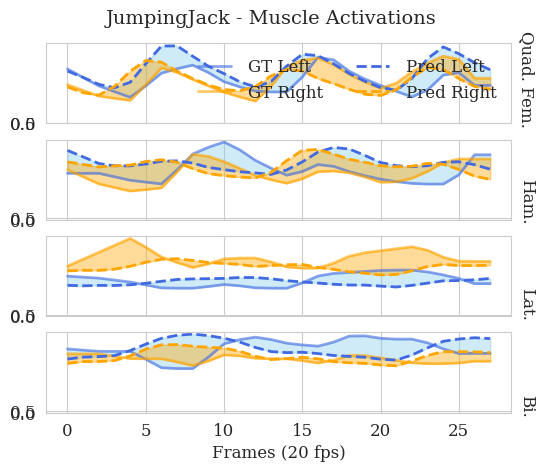

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

sns.set_style(style="whitegrid")


# Set global plot parameters for consistent styling
plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (6, 4.8),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)


for sample_idx in sample_indices:

    key = keys[sample_idx]

    action = action_data[key]

    gt = gts[sample_idx]
    pred = preds[sample_idx]

    T, D = gt.shape
    plt.figure()

    counter = 0

    for li in range(0, int(len(muscle_idxs) / 2)):
        ri = li + int(len(muscle_idxs) / 2)  # Right index

        muscle_l = MIA_MUSCLES[muscle_idxs[li]]
        muscle_r = MIA_MUSCLES[muscle_idxs[ri]]

        muscle_name_l = full_muscle_names[muscle_l]
        muscle_name_r = full_muscle_names[muscle_r]

        counter += 1

        plt.subplot(int(D / 2), 1, counter)

        x = np.arange(len(gt[:, li]))
        x_new = np.linspace(x.min(), x.max(), len(x) * 10)

        gt_l = gt[:, li]
        gt_r = gt[:, ri]

        pred_l = pred[:, li]
        # pred_l = interp1d(x, pred_l, kind="cubic")(x_new)

        pred_r = pred[:, ri]

        plt.plot(gt_l, label=f"GT Left", linewidth=2, color="royalblue", alpha=0.6)
        plt.plot(gt_r, label=f"GT Right", linewidth=2, color="orange", alpha=0.6)

        plt.plot(pred_l, label=f"Pred Left", linestyle="--", linewidth=2, color="royalblue")
        plt.plot(pred_r, label=f"Pred Right", linestyle="--", linewidth=2, color="orange")

        plt.fill_between(range(len(gt_l)), gt_l, pred_l, color="skyblue", alpha=0.4)
        plt.fill_between(range(len(gt_r)), gt_r, pred_r, color="orange", alpha=0.4)
        plt.yticks([0, 0.5])
        plt.title(f"{muscle_name_l[:-4]}", rotation=-90, loc="right", x=1.05, y=-0.11)

        # plt.ylabel(f"Activation")
        # Hide x-axis for all but the last subplot
        if counter != int(D / 2):
            # plt.yticks([])
            # plt.gca().xaxis.set_ticks([])
            plt.gca().set_xticklabels([])
            plt.gca().xaxis.grid(True)  # Ensure x-axis grid is visible
        else:
            plt.xlabel("Frames (20 fps)")

        # plt.ylim((0, 0.9))
        plt.grid(True)

    # plt.ylabel(f"Activation", y=2.2)
    plt.legend(loc="upper right", bbox_to_anchor=(1.0012, 4.59), ncol=2, frameon=False, handletextpad=1)
    plt.tight_layout()
    plt.suptitle(f"{action} - Muscle Activations", fontsize=14, y=0.95)
    # plt.savefig(f"{sample_idx}_{action}.svg")
    plt.show()